# Imports

In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline

In [13]:
import json, pickle, array, datetime, pickle
from tqdm import trange, tqdm

from statistics import mean, stdev

import tensorflow as tf
from tensorflow.keras.models import load_model
from dataset.dataset_padchest import *

from deap import base, creator, tools

from collections import Counter, defaultdict
import seaborn as sns
from tabulate import tabulate

from XAI.evaluation import *
from XAI.pareto_front import *
from XAI.image_utils import *
from XAI.genetic_algorithm import *

In [4]:
@tf.function()
def sampling(args):
    z_mean, z_log_sigma = args
    epsilon = tf.random.normal(shape=(tf.shape(z_mean)[0], config['model']['latent_dim']), mean=0., stddev=0.1)
    return z_mean + tf.math.exp(z_log_sigma) * epsilon

# Data and model load

In [5]:
with open('config.json', 'r') as f:
    config = json.load(f)

In [6]:
data = Dataset(config)

with open("dataset.pkl", 'rb') as f:
    data = pickle.load(f)

In [7]:
LABELS = sorted(config["padchest"]["label_names"], key=config["padchest"]["label_names"].get)

# Load models

In [8]:
MODEL_PATH = 'results_padchest_v2_MOCVAE'

In [9]:
autoencoder = load_model(MODEL_PATH + '/models/e_best_autoencoder.h5', custom_objects={'sampling': sampling})
encoder = load_model(MODEL_PATH + '/models/e_best_encoder.h5', custom_objects={'sampling': sampling})
decoder = load_model(MODEL_PATH + '/models/e_best_decoder.h5', custom_objects={'sampling': sampling})
classifier = load_model(MODEL_PATH + '/models/e_best_classifier.h5', custom_objects={'sampling': sampling})

/opt/conda/lib/python3.8/site-packages/tensorflow/python/keras/layers/core.py:1043: UserWarning: models.model_MOCVAE is not loaded, but a Lambda layer uses it. It may cause errors.
  warnings.warn('{} is not loaded, but a Lambda layer uses it. '


In [10]:
with open("full_dict_undersampling_v2_MOCVAE.pkl", 'rb') as f:
    full_dict = pickle.load(f)

# Get populations

In [18]:
def get_base_latent_codes():
    n_tests = 10
    latent_codes = dict()
    original_ids = dict()

    for label_base in LABELS:
        latent_codes[label_base] = []
        original_ids[label_base] = []
        img_id = 0
        
        pbar = tqdm(range(n_tests))
        for i in pbar:
            pbar.set_description(label_base)
            enc=0
            while enc==0:
                # Find base case from a specific label
                if LABELS[np.argmax(data.y_train[img_id])] == label_base:

                    # Find base case with confidence > 80%
                    input_img = data.X_train[img_id].reshape(1,224,224,1)
                    latent_code = encoder.predict(input_img)
                    latent_code = np.copy(latent_code[2])
                    classification = classifier.predict(latent_code)
                    conf = classification[0][LABELS.index(label_base)]

                    if conf > 0.8:
                        enc=1
                    else:
                        img_id+=1

                else:
                    img_id+=1

            latent_codes[label_base].append(latent_code[0])
            original_ids[label_base].append(img_id)
            img_id+=1
            
    return original_ids, latent_codes

In [19]:
original_ids, latent_codes = get_base_latent_codes()

normal: 100%|██████████| 10/10 [00:17<00:00,  1.74s/it]


# Transition matrix

In [207]:
labels = ['normal', 'cardiomegaly', 'scoliosis', 'aortic elongation']

In [208]:
tran_matrix_mean = np.empty([len(labels), len(labels)])

for i, label_base in enumerate(labels):
    for j, label_obj in enumerate(labels):
        if i==j:
            tran_matrix_mean[i][j] = 0
        else:
            tran_matrix_mean[i][j] = -np.mean(full_dict[label_base][label_obj]['means'][label_base])

In [209]:
tran_matrix_std = np.empty([len(labels), len(labels)])

for i, label_base in enumerate(labels):
    for j, label_obj in enumerate(labels):
        if i==j:
            tran_matrix_std[i][j] = 0
        else:
            tran_matrix_std[i][j] = np.mean(full_dict[label_base][label_obj]['stds'][label_base])

In [212]:
tran_matrix = np.empty((len(tran_matrix_mean), len(tran_matrix_mean[0])), dtype='U20')
for i in range(len(tran_matrix)):
    for j in range(len(tran_matrix[0])):
        tran_matrix[i][j] = f"{tran_matrix_mean[i][j]:.4f}" + '+-' + f"{tran_matrix_std[i][j]:.2f}"

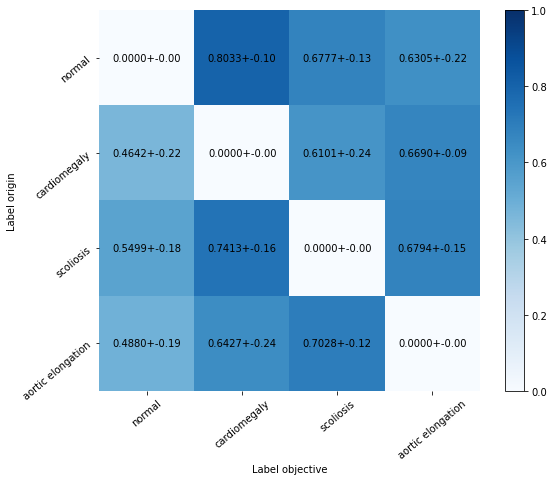

In [213]:
plt.figure(figsize=(9,7))
heatmap = plt.imshow(tran_matrix_mean, cmap='Blues', interpolation='nearest', vmin=0, vmax=1)

for i in range(len(tran_matrix_mean)):
    for j in range(len(tran_matrix_mean[i])):
        plt.text(j, i, tran_matrix[i, j], ha='center', va='center', color='black')

# Agregar la barra de color
plt.colorbar(heatmap)
plt.xticks(np.arange(len(labels)), labels, rotation=40)
plt.yticks(np.arange(len(labels)), labels, rotation=40)
plt.xlabel("Label objective")
plt.ylabel("Label origin")

plt.box(False)
plt.show()

In [215]:
for i in range(len(tran_matrix)):
    for j in range(len(tran_matrix[0])):
        tran_matrix[i][j] = tran_matrix[i][j].replace("+-", "$\pm$")
        
print(tabulate(tran_matrix, tablefmt="latex_raw"))

\begin{tabular}{llll}
\hline
 0.0000$\pm$0.00 & 0.8033$\pm$0.10 & 0.6777$\pm$0.13 & 0.6305$\pm$0.22 \\
 0.4642$\pm$0.22 & 0.0000$\pm$0.00 & 0.6101$\pm$0.24 & 0.6690$\pm$0.09 \\
 0.5499$\pm$0.18 & 0.7413$\pm$0.16 & 0.0000$\pm$0.00 & 0.6794$\pm$0.15 \\
 0.4880$\pm$0.19 & 0.6427$\pm$0.24 & 0.7028$\pm$0.12 & 0.0000$\pm$0.00 \\
\hline
\end{tabular}


In [229]:
total = 0
cont = 0

for row in tran_matrix_mean:
    for elem in row:
        if elem != 0.0:
            total += elem
            cont += 1

print(f"Mean value: {(total / cont):.4f}")

tran_matrix_mean_no_zero = tran_matrix_mean[tran_matrix_mean != 0]
print(f"\nMin value: {np.min(tran_matrix_mean_no_zero):.4f}")
print(f"Max value: {np.max(tran_matrix_mean_no_zero):.4f}")

Mean value: 0.6382

Min value: 0.4642
Max value: 0.8033


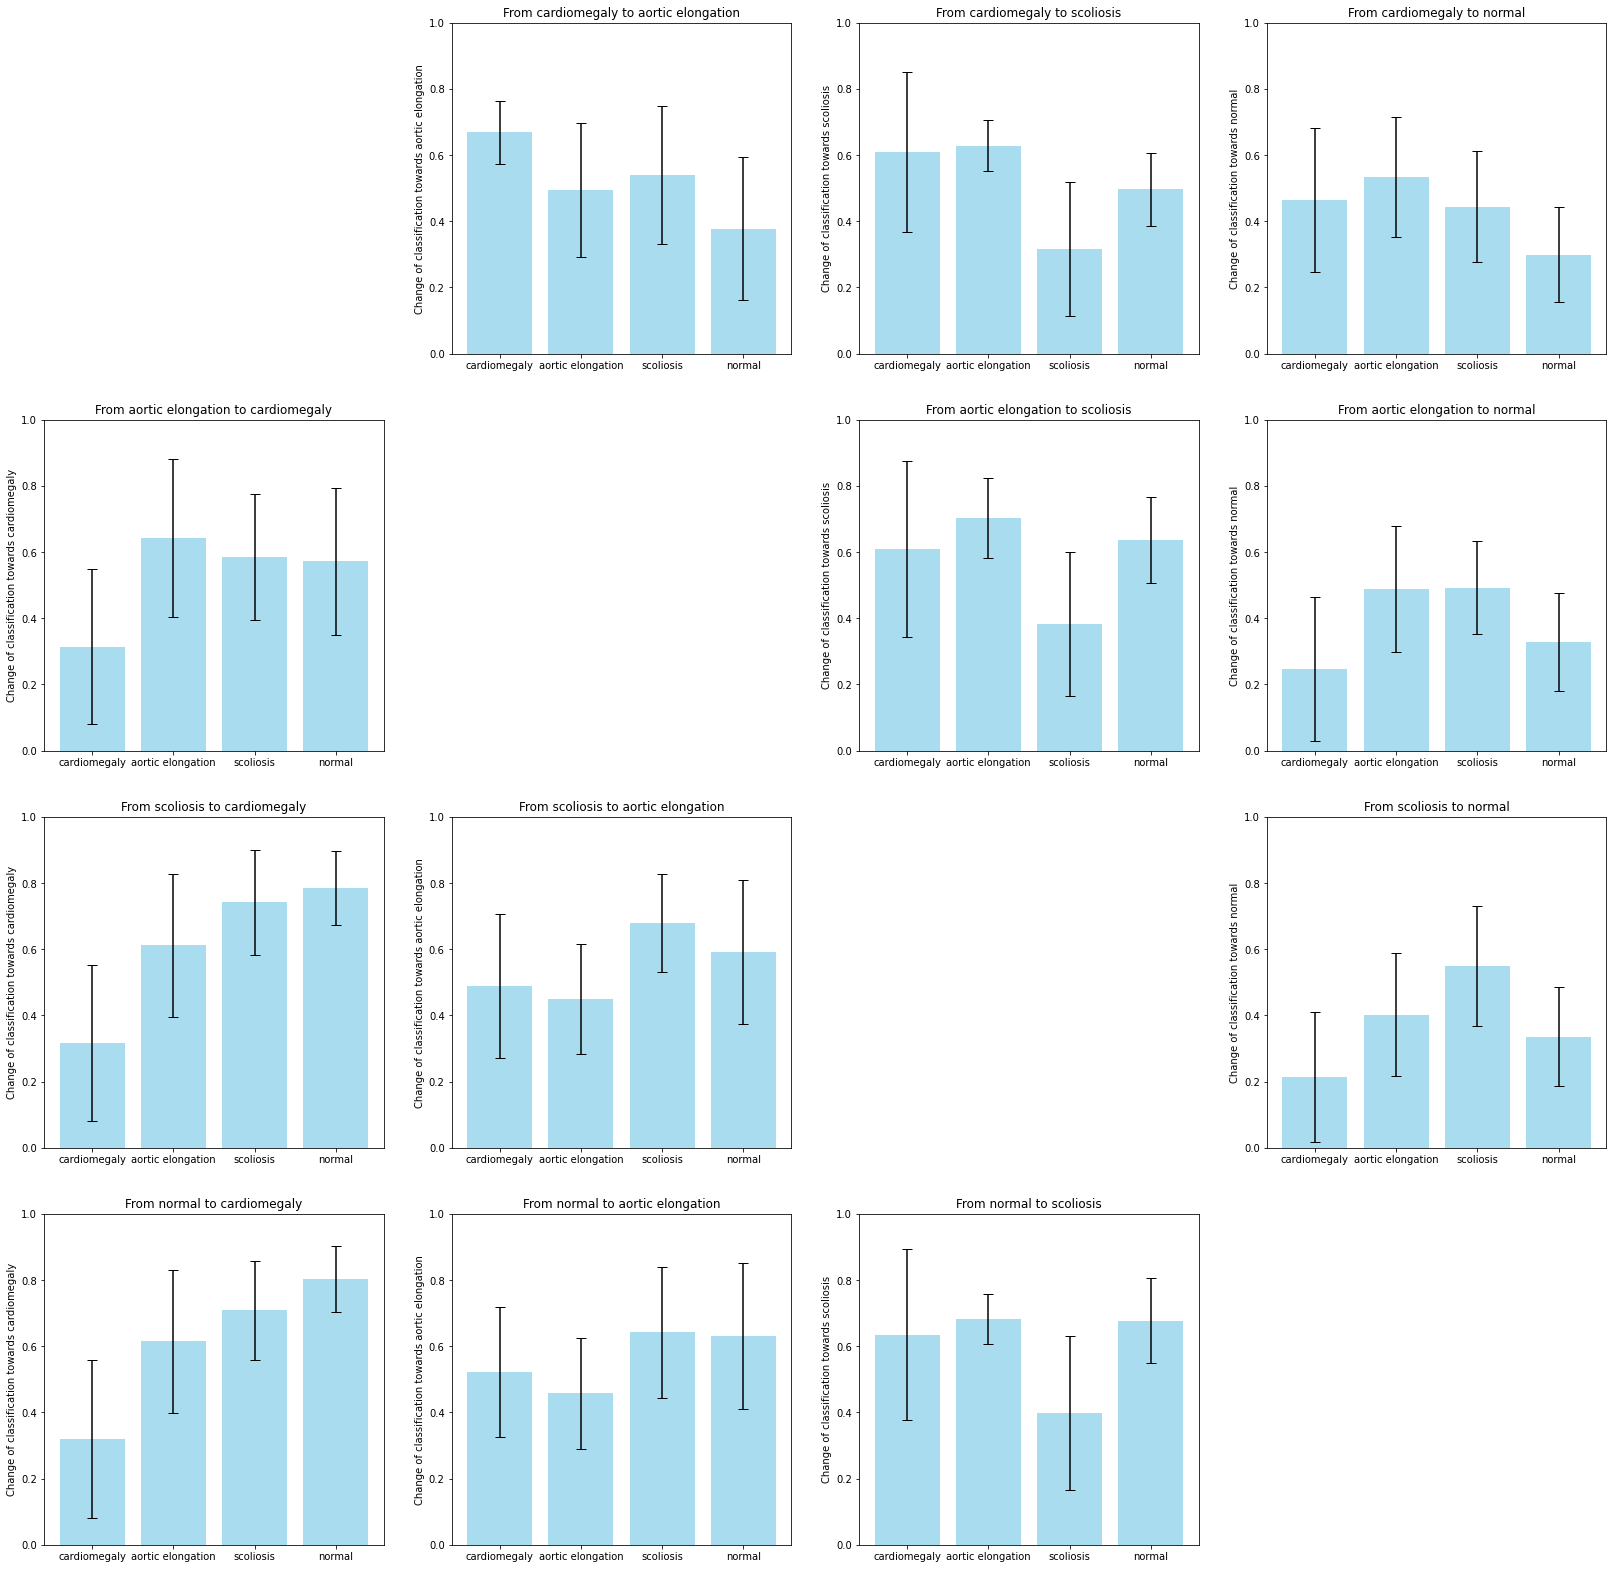

In [221]:
fig, ax = plt.subplots(len(full_dict.keys()), len(full_dict.keys()),
                       figsize=(7*len(full_dict.keys()),7*len(full_dict.keys())))

for i, label_base in enumerate(full_dict.keys()):
    for j, label_obj in enumerate(full_dict[label_base].keys()):
        
        if i!=j:
            class_labels = full_dict[label_base][label_obj]['means'].keys()
            miss_list = list(full_dict[label_base][label_obj]['means'].values())
            miss_means = -np.mean(miss_list, axis=1)
            error_list = list(full_dict[label_base][label_obj]['stds'].values())
            error_means = np.mean(error_list, axis=1)
            
            ax[i][j].bar(class_labels, miss_means, yerr=error_means,
                   capsize=5, color='skyblue', alpha=0.7)

            # Configure title and labels
            ax[i][j].set_title('From ' + label_base + ' to ' + label_obj)
            ax[i][j].set_ylabel('Change of classification towards ' + label_obj)
            ax[i][j].set_ylim([0,1])
        
        else:
            ax[i][j].axis('off')
        
plt.show()

# Successfull individuals

## First successfull

In [239]:
labels = ['normal', 'cardiomegaly', 'scoliosis', 'aortic elongation']

In [240]:
df_data = {
    'cardiomegaly': [None, None, None, None],
    'aortic elongation': [None, None, None, None],
    'scoliosis': [None, None, None, None],
    'normal': [None, None, None, None]
}

df = pd.DataFrame(df_data, index=labels, columns=labels)
df_stds = pd.DataFrame(df_data, index=labels, columns=labels)

for i, label_base in enumerate(full_dict.keys()):
    for j, label_obj in enumerate(full_dict[label_base].keys()):
        if i!=j:
            first_miss = []
            for hist in full_dict[label_base][label_obj]['histories']:
                if any(value!=0 for value in hist):
                    first_miss.append(min([i for i, num in enumerate(hist) if num > 0]))
                
            df.at[label_base, label_obj] = np.mean(first_miss)
            df_stds.at[label_base, label_obj] = np.std(first_miss)

In [241]:
df = df.fillna(0)
df_stds = df_stds.fillna(0)
df_combined = df.applymap(lambda x: f"{x:.1f}") + '+-' + df_stds.applymap(lambda x: f"{x:.0f}")

In [242]:
df_combined

normal cardiomegaly scoliosis aortic elongation
normal               0.0+-0     64.1+-31  42.1+-25          69.9+-32
cardiomegaly       99.2+-43       0.0+-0  76.9+-42          60.9+-43
scoliosis          27.3+-15     52.9+-23    0.0+-0          86.8+-45
aortic elongation  66.2+-34     73.5+-36  53.7+-40            0.0+-0

In [243]:
df_combined = df_combined.applymap(lambda x: x.replace('+-', '$\pm$'))
        
print(tabulate(df_combined, tablefmt="latex_raw"))

\begin{tabular}{lllll}
\hline
 normal            & 0.0$\pm$0   & 64.1$\pm$31 & 42.1$\pm$25 & 69.9$\pm$32 \\
 cardiomegaly      & 99.2$\pm$43 & 0.0$\pm$0   & 76.9$\pm$42 & 60.9$\pm$43 \\
 scoliosis         & 27.3$\pm$15 & 52.9$\pm$23 & 0.0$\pm$0   & 86.8$\pm$45 \\
 aortic elongation & 66.2$\pm$34 & 73.5$\pm$36 & 53.7$\pm$40 & 0.0$\pm$0   \\
\hline
\end{tabular}


In [244]:
print(f"Mean value: {df[df != 0].stack().mean():.4f}")

print(f"\nMin value: {np.min(df.values[df.values != 0]):.4f}")
print(f"Max value: {np.max(df.values[df.values != 0]):.4f}")

Mean value: 64.4583

Min value: 27.3000
Max value: 99.2000


## Final success rate

In [245]:
labels = ['normal', 'cardiomegaly', 'scoliosis', 'aortic elongation']

In [246]:
df_data = {
    'normal': [None, None, None, None],
    'cardiomegaly': [None, None, None, None],
    'scoliosis': [None, None, None, None],
    'aortic elongation': [None, None, None, None]
}

df = pd.DataFrame(df_data, index=labels, columns=labels)
df_stds = pd.DataFrame(df_data, index=labels, columns=labels)

for i, label_base in enumerate(labels):
    for j, label_obj in enumerate(labels):
        if i!=j:
            final_success = []
            for hist in full_dict[label_base][label_obj]['histories']:
                if any(value!=0 for value in hist):
                    final_success.append(hist[-1])
                
            df.at[label_base, label_obj] = np.mean(final_success)
            df_stds.at[label_base, label_obj] = np.std(final_success)

In [247]:
df = df.fillna(0)
df_stds = df_stds.fillna(0)
df_combined = df.applymap(lambda x: f"{x*100:.2f}") + '+-' + df_stds.applymap(lambda x: f"{x*100:.1f}" + '%')

In [248]:
df_combined

normal  cardiomegaly     scoliosis aortic elongation
normal               0.00+-0.0%  87.87+-11.3%   98.62+-2.1%      84.62+-12.5%
cardiomegaly       74.50+-18.6%    0.00+-0.0%  77.75+-20.3%      89.88+-11.2%
scoliosis           98.88+-1.7%  89.50+-10.8%    0.00+-0.0%      76.50+-17.2%
aortic elongation  82.88+-15.7%  82.88+-16.1%  93.50+-14.5%        0.00+-0.0%

In [249]:
df_combined = df_combined.applymap(lambda x: x.replace('+-', '$\pm$'))
        
print(tabulate(df_combined, tablefmt="latex_raw"))

\begin{tabular}{lllll}
\hline
 normal            & 0.00$\pm$0.0%   & 87.87$\pm$11.3% & 98.62$\pm$2.1%  & 84.62$\pm$12.5% \\
 cardiomegaly      & 74.50$\pm$18.6% & 0.00$\pm$0.0%   & 77.75$\pm$20.3% & 89.88$\pm$11.2% \\
 scoliosis         & 98.88$\pm$1.7%  & 89.50$\pm$10.8% & 0.00$\pm$0.0%   & 76.50$\pm$17.2% \\
 aortic elongation & 82.88$\pm$15.7% & 82.88$\pm$16.1% & 93.50$\pm$14.5% & 0.00$\pm$0.0%   \\
\hline
\end{tabular}


In [250]:
print(f"Mean value: {df[df != 0].stack().mean():.4f}")

print(f"\nMin value: {np.min(df.values[df.values != 0]):.4f}")
print(f"Max value: {np.max(df.values[df.values != 0]):.4f}")

Mean value: 0.8645

Min value: 0.7450
Max value: 0.9888


## Success evolution during trainings

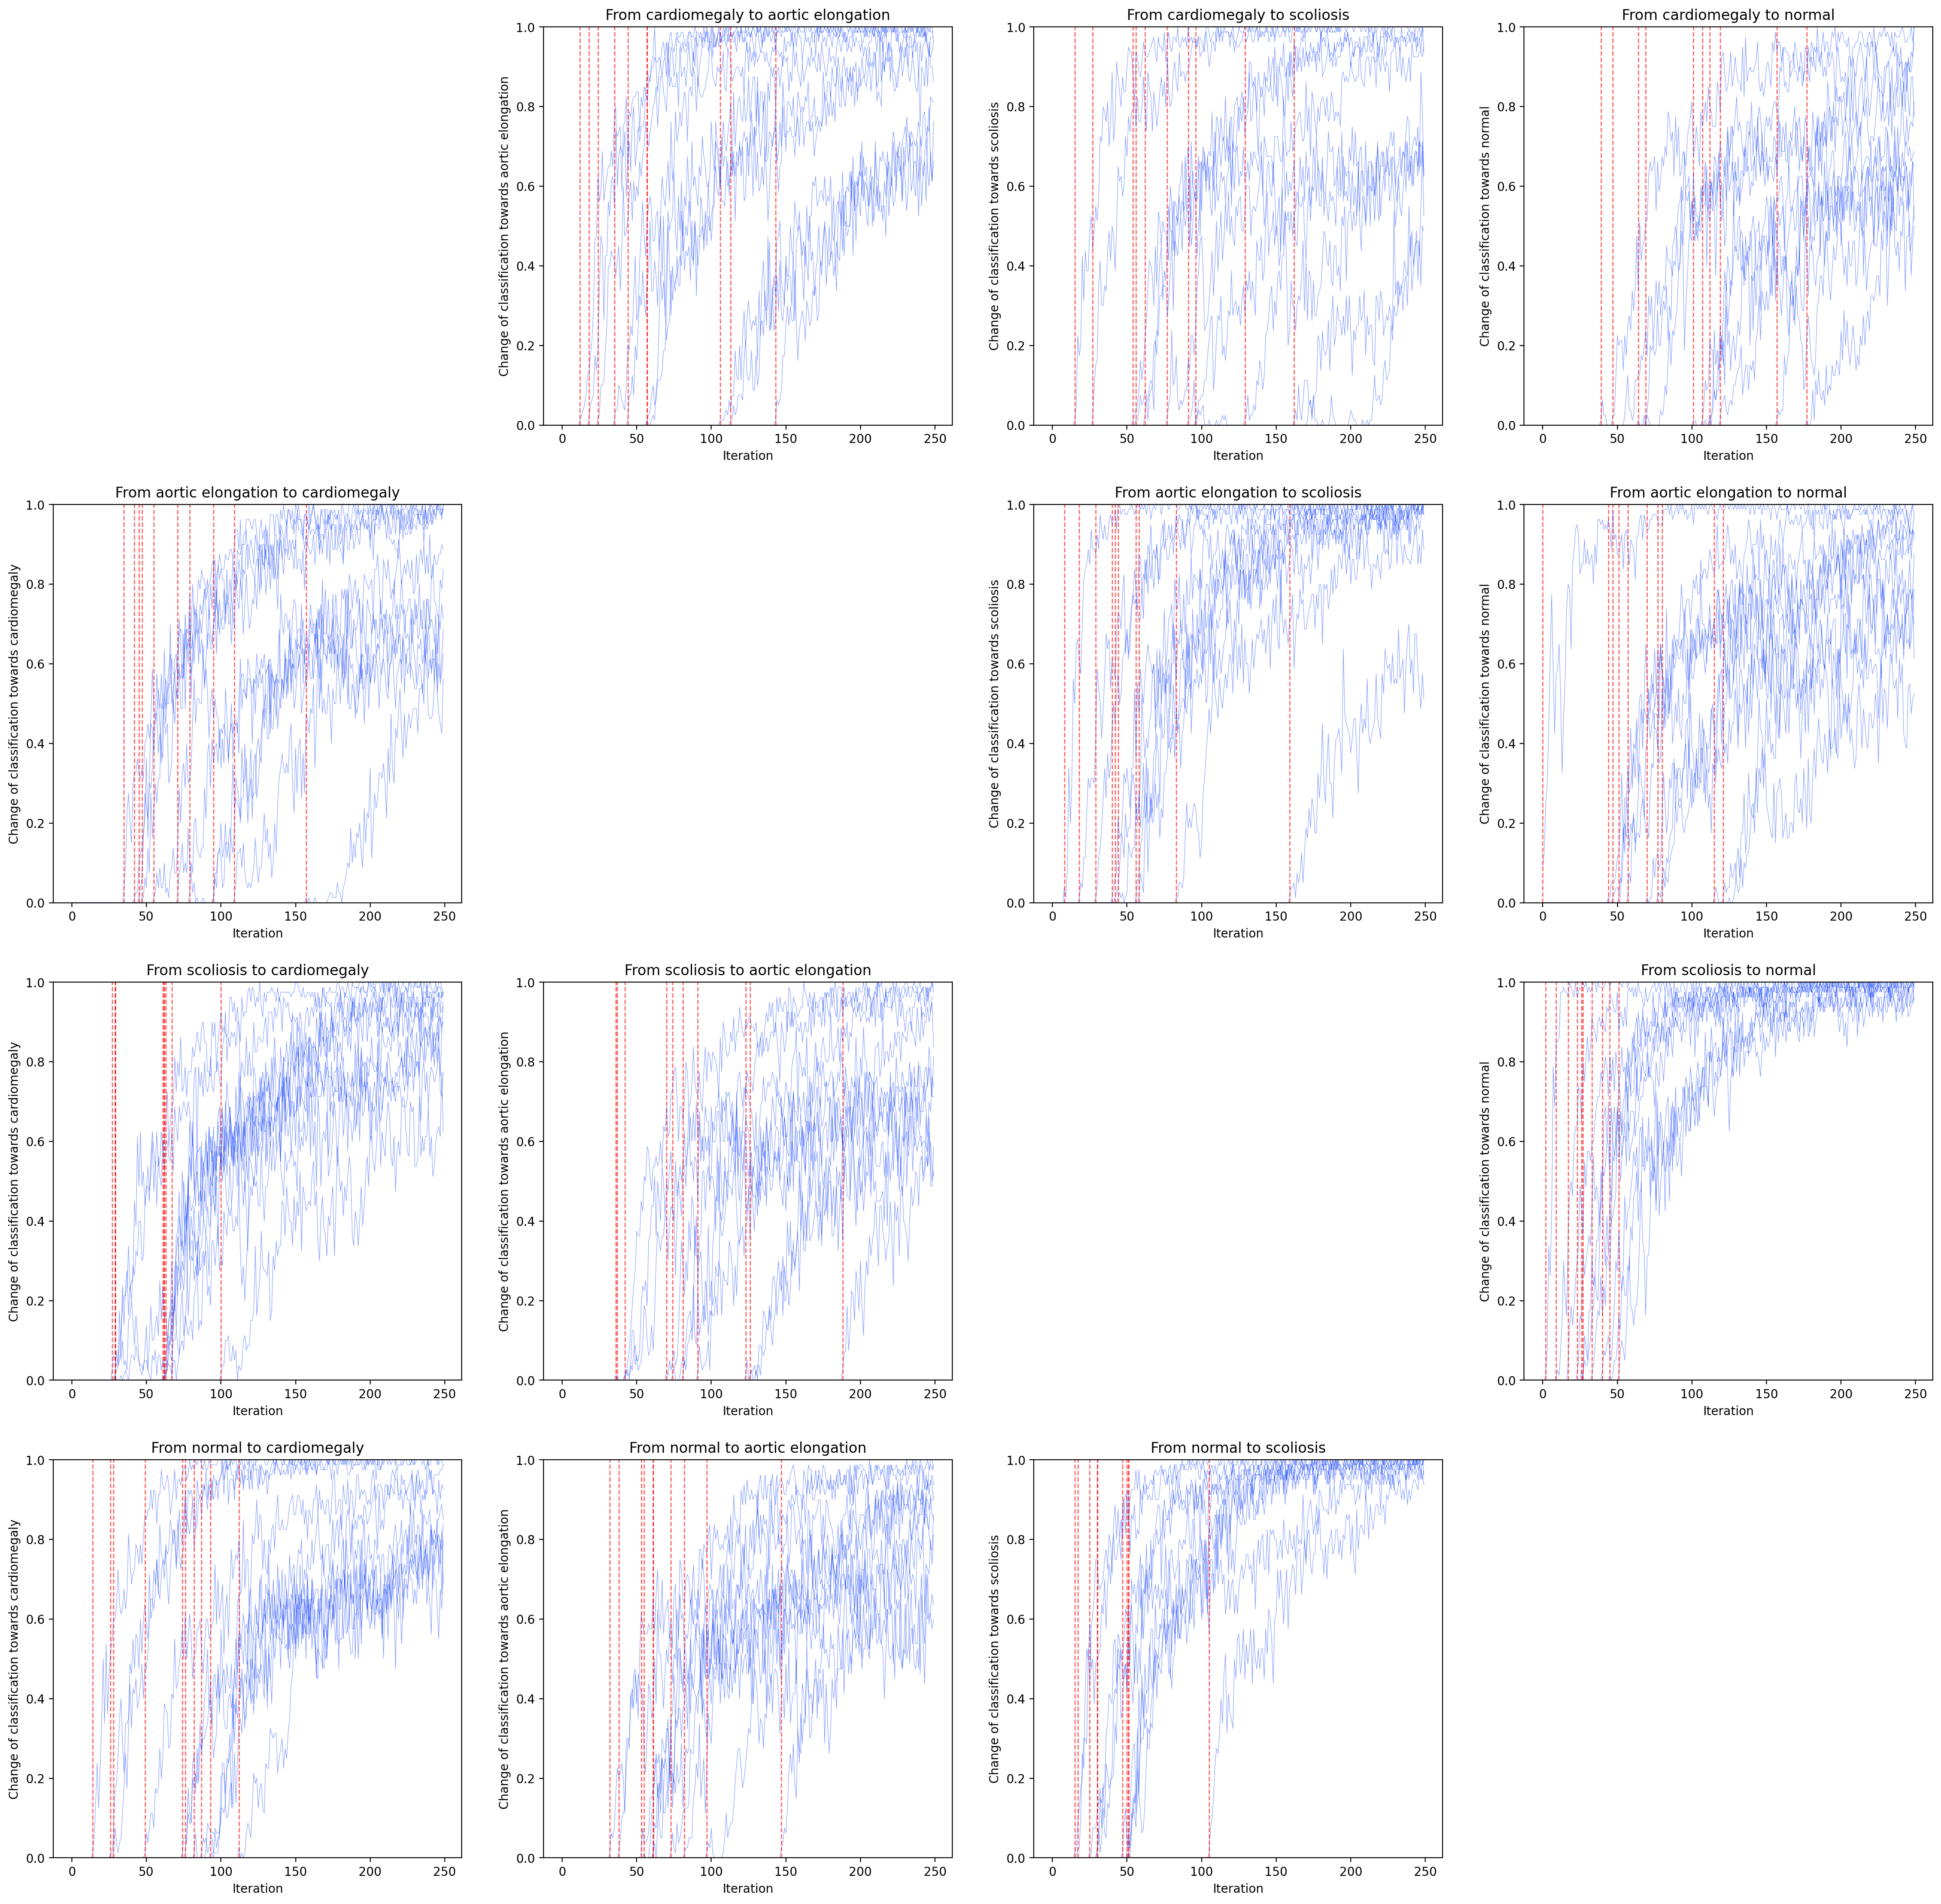

In [26]:
fig, ax = plt.subplots(len(full_dict.keys()), len(full_dict.keys()),
                       figsize=(7*len(full_dict.keys()),7*len(full_dict.keys())), dpi=200)

for i, label_base in enumerate(full_dict.keys()):
    for j, label_obj in enumerate(full_dict[label_base].keys()):
        
        if i!=j:
            for hist in full_dict[label_base][label_obj]['histories']:
                ax[i][j] = plot_miss_history(ax[i][j], hist, first_text=False)

            # Configure title and labels
            ax[i][j].set_title('From ' + label_base + ' to ' + label_obj)
            ax[i][j].set_ylabel('Change of classification towards ' + label_obj)
        
        else:
            ax[i][j].axis('off')
        
plt.show()

# Get pareto frontiers

In [ ]:
pareto_frontiers = dict()

for label_base in LABELS:
    pareto_frontiers[label_base] = dict()
    
    for label_obj in LABELS:
        pareto_frontiers[label_base][label_obj] = dict()
        if label_base != label_obj:
            
            for i in trange(len(latent_codes[label_base]),
                            desc=label_base + '-' + label_obj):
                    
                pareto_frontiers[label_base][label_obj][i] = dict()
                latent_code = latent_codes[label_base][i]
                final_set = full_dict[label_base][label_obj]['population'][i]
                fitnesses = evaluate_pop(final_set, latent_code, classifier, label_obj, LABELS)
                class_chs = get_class_changes_obj(latent_code, classifier, final_set, label_obj, LABELS)

                pareto_frontiers[label_base][label_obj][i]['final_set'] = final_set
                pareto_frontiers[label_base][label_obj][i]['fitnesses'] = fitnesses
                pareto_frontiers[label_base][label_obj][i]['class_chs'] = class_chs

aortic elongation-cardiomegaly:  50%|█████     | 5/10 [00:40<00:42,  8.43s/it]

# Minimum number of changes

In [251]:
labels = ['normal', 'cardiomegaly', 'scoliosis', 'aortic elongation']

In [ ]:
df_data = {
    'normal': [None, None, None, None],
    'cardiomegaly': [None, None, None, None],
    'scoliosis': [None, None, None, None],
    'aortic elongation': [None, None, None, None]
}

df = pd.DataFrame(df_data, index=labels, columns=labels)
df_stds = pd.DataFrame(df_data, index=labels, columns=labels)

for label_base in labels:
    for label_obj in labels:
        min_num_changes = []
        for i in range(len(pareto_frontiers[label_base][label_obj])):
            class_chs = pareto_frontiers[label_base][label_obj][i]['class_chs']
            fitnesses = pareto_frontiers[label_base][label_obj][i]['fitnesses']
            fitnesses_purged = [fitnesses[j] for j in range(len(class_chs)) if class_chs[j] == 1]
            
            if len(fitnesses_purged) > 0:
                fitnesses_purged = np.array(fitnesses_purged)
                min_num_changes.append(min(fitnesses_purged[:,2]))
                
        df.at[label_base, label_obj] = np.mean(min_num_changes)
        df_stds.at[label_base, label_obj] = np.std(min_num_changes)

In [253]:
df = df.fillna(0)
df_stds = df_stds.fillna(0)
df_combined = df.applymap(lambda x: f"{x:.2f}") + '+-' + df_stds.applymap(lambda x: f"{x:.1f}")

In [254]:
df_combined

normal cardiomegaly    scoliosis aortic elongation
normal               0.00+-0.0   17.40+-8.5  49.50+-21.4       26.30+-15.3
cardiomegaly       25.90+-20.8    0.00+-0.0  51.60+-24.1       51.70+-51.9
scoliosis          99.89+-69.3  19.10+-10.6    0.00+-0.0       56.80+-48.3
aortic elongation  26.40+-29.1  34.00+-16.1  31.10+-15.2         0.00+-0.0

In [255]:
df_combined = df_combined.applymap(lambda x: x.replace('+-', '$\pm$'))
        
print(tabulate(df_combined, tablefmt="latex_raw"))

\begin{tabular}{lllll}
\hline
 normal            & 0.00$\pm$0.0   & 17.40$\pm$8.5  & 49.50$\pm$21.4 & 26.30$\pm$15.3 \\
 cardiomegaly      & 25.90$\pm$20.8 & 0.00$\pm$0.0   & 51.60$\pm$24.1 & 51.70$\pm$51.9 \\
 scoliosis         & 99.89$\pm$69.3 & 19.10$\pm$10.6 & 0.00$\pm$0.0   & 56.80$\pm$48.3 \\
 aortic elongation & 26.40$\pm$29.1 & 34.00$\pm$16.1 & 31.10$\pm$15.2 & 0.00$\pm$0.0   \\
\hline
\end{tabular}


In [256]:
print(f"Mean value: {df[df != 0].stack().mean():.4f}")

print(f"\nMin value: {np.min(df.values[df.values != 0]):.4f}")
print(f"Max value: {np.max(df.values[df.values != 0]):.4f}")

Mean value: 40.8074

Min value: 17.4000
Max value: 99.8889


# Minimum changes magnitude

In [263]:
labels = ['normal', 'cardiomegaly', 'scoliosis', 'aortic elongation']

In [ ]:
df_data = {
    'normal': [None, None, None, None],
    'cardiomegaly': [None, None, None, None],
    'scoliosis': [None, None, None, None],
    'aortic elongation': [None, None, None, None]
}

df = pd.DataFrame(df_data, index=labels, columns=labels)
df_stds = pd.DataFrame(df_data, index=labels, columns=labels)

for label_base in labels:
    for label_obj in labels:
        min_mag_changes = []
        for i in range(len(pareto_frontiers[label_base][label_obj])):
            class_chs = pareto_frontiers[label_base][label_obj][i]['class_chs']
            fitnesses = pareto_frontiers[label_base][label_obj][i]['fitnesses']
            fitnesses_purged = [fitnesses[j] for j in range(len(class_chs)) if class_chs[j] == 1]
            
            if len(fitnesses_purged) > 0:
                fitnesses_purged = np.array(fitnesses_purged)
                min_mag_changes.append(min(fitnesses_purged[:,1]))
            
        df.at[label_base, label_obj] = np.mean(min_mag_changes)
        df_stds.at[label_base, label_obj] = np.std(min_mag_changes)

In [265]:
df = df.fillna(0)
df_stds = df_stds.fillna(0)
df_combined = df.applymap(lambda x: f"{x:.2f}") + '+-' + df_stds.applymap(lambda x: f"{x:.1f}")

In [266]:
df_combined

normal cardiomegaly  scoliosis aortic elongation
normal               0.00+-0.0    1.45+-1.1  8.72+-3.8         3.07+-3.0
cardiomegaly         4.13+-4.3    0.00+-0.0  8.74+-3.8         8.53+-8.8
scoliosis          17.62+-13.1    1.42+-2.2  0.00+-0.0         9.21+-8.6
aortic elongation    3.76+-5.5    5.50+-3.0  5.20+-3.0         0.00+-0.0

In [267]:
df_combined = df_combined.applymap(lambda x: x.replace('+-', '$\pm$'))
        
print(tabulate(df_combined, tablefmt="latex_raw"))

\begin{tabular}{lllll}
\hline
 normal            & 0.00$\pm$0.0   & 1.45$\pm$1.1 & 8.72$\pm$3.8 & 3.07$\pm$3.0 \\
 cardiomegaly      & 4.13$\pm$4.3   & 0.00$\pm$0.0 & 8.74$\pm$3.8 & 8.53$\pm$8.8 \\
 scoliosis         & 17.62$\pm$13.1 & 1.42$\pm$2.2 & 0.00$\pm$0.0 & 9.21$\pm$8.6 \\
 aortic elongation & 3.76$\pm$5.5   & 5.50$\pm$3.0 & 5.20$\pm$3.0 & 0.00$\pm$0.0 \\
\hline
\end{tabular}


In [268]:
print(f"Mean value: {df[df != 0].stack().mean():.4f}")

print(f"\nMin value: {np.min(df.values[df.values != 0]):.4f}")
print(f"Max value: {np.max(df.values[df.values != 0]):.4f}")

Mean value: 6.4452

Min value: 1.4153
Max value: 17.6219


# Min magnitude empirical evaluation

In [ ]:
out_base_path = 'XAI_evaluation_undersampling/MOCVAE/min_mag/'
for label_base in LABELS:
    for label_obj in LABELS:
        print(label_base, label_obj)
        for i in range(len(pareto_frontiers[label_base][label_obj])):
            final_set = pareto_frontiers[label_base][label_obj][i]['final_set']
            fitnesses = pareto_frontiers[label_base][label_obj][i]['fitnesses']
            class_chs = pareto_frontiers[label_base][label_obj][i]['class_chs']
            
            # Purge unsuccessful individuals
            final_set_purged = [final_set[j] for j in range(len(class_chs)) if class_chs[j] == 1]
            fitnesses_purged = [list(fitnesses[j][1:]) for j in range(len(class_chs)) if class_chs[j] == 1]
            
            if len(final_set_purged) > 0:
                idx_min_mag = min(range(len(fitnesses_purged)), key=lambda i: fitnesses_purged[i][0])
                
                min_mag_ind = final_set_purged[idx_min_mag]

                out_path = out_base_path + label_base + '-' + label_obj + '_' + str(i)
                plot_ind_changes(data, encoder, decoder, classifier,
                                 original_ids[label_base][i], min_mag_ind, LABELS, out_path)
                

# Min number of changes empirical evaluation

In [ ]:
out_base_path = 'XAI_evaluation_undersampling/MOCVAE/min_num/'
for label_base in LABELS:
    for label_obj in LABELS:
        for i in range(len(pareto_frontiers[label_base][label_obj])):
            print(label_base, label_obj, i)
            final_set = pareto_frontiers[label_base][label_obj][i]['final_set']
            fitnesses = pareto_frontiers[label_base][label_obj][i]['fitnesses']
            class_chs = pareto_frontiers[label_base][label_obj][i]['class_chs']
            
            # Purge unsuccessful individuals
            final_set_purged = [final_set[j] for j in range(len(class_chs)) if class_chs[j] == 1]
            fitnesses_purged = [list(fitnesses[j][1:]) for j in range(len(class_chs)) if class_chs[j] == 1]
            
            if len(final_set_purged) > 0:
                idx_min_num = min(range(len(fitnesses_purged)), key=lambda i: fitnesses_purged[i][1])
                
                min_num_ind = final_set_purged[idx_min_num]

                out_path = out_base_path + label_base + '-' + label_obj + '_' + str(i)
                plot_ind_changes(data, encoder, decoder, classifier,
                                 original_ids[label_base][i], min_mag_ind, LABELS, out_path)